# WTI Price Prediction - Model Exploration and Selection.

This notebook explores machine learning models and hyperparameters 
to find the optimal parametres for predicting WTI oil prices.

## 1. Set up and data loading

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Get project root directory
def get_project_root():
    """Get the project root directory where data, models, notebook, and src folders are located"""
    current_dir = os.getcwd()
    # Go up one level if we're in a subdirectory (like 'notebook' or 'src')
    if os.path.basename(current_dir) in ['notebook', 'src', 'data']:
        return os.path.dirname(current_dir)
    return current_dir

def get_latest_training_file():
    """Get the most recent training data file."""
    data_dir = os.path.join(get_project_root(), 'data', 'training_ready')
    files = glob.glob(os.path.join(data_dir, 'training_data_*.csv'))
    if not files:
        raise FileNotFoundError("No training data files found")
    return max(files)

## 2. Data preparation

In [15]:
def prepare_data(df):
    """Prepare data for training."""
    # Drop any rows with missing values
    df = df.dropna()
    
    # Separate features and target
    X = df.drop(['wti', 'date'], axis=1)
    y = df['wti']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    return X_scaled, y, scaler

In [16]:
def objective(trial):
    """Optuna objective function optimizing for directional accuracy."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    model = xgb.XGBRegressor(**params, random_state=42)
    
    # Use TimeSeriesSplit for evaluation
    tscv = TimeSeriesSplit(n_splits=5)
    directional_accuracies = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train_cv = X.iloc[train_idx]
        y_train_cv = y.iloc[train_idx]
        X_val_cv = X.iloc[val_idx]
        y_val_cv = y.iloc[val_idx]
        
        model.fit(
            X_train_cv,
            y_train_cv,
            verbose=False
        )
        
        # Calculate directional accuracy using numpy arrays
        y_pred = model.predict(X_val_cv)
        y_val_np = y_val_cv.values
        
        # Convert to direction changes using numpy
        actual_direction = np.sign(np.diff(y_val_np))
        pred_direction = np.sign(np.diff(y_pred))
        
        # Calculate accuracy
        matches = (actual_direction == pred_direction)
        da = np.mean(matches) * 100
        directional_accuracies.append(da)
    
    return -np.mean(directional_accuracies)  # Negative since Optuna minimizes

In [17]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate model performance using RMSE, MAE, and Directional Accuracy."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Add MAPE calculation
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Calculate Directional Accuracy
    y_pred_series = pd.Series(y_pred, index=y_test.index)
    actual_direction = np.sign(y_test.diff().fillna(0))
    pred_direction = np.sign(y_pred_series.diff().fillna(0))
    matches = (actual_direction == pred_direction).astype(int)
    da = np.mean(matches) * 100
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'da': da,
        'model': model
    }

In [18]:
# Load and prepare data
print("Loading training data...")
training_file = get_latest_training_file()
df = pd.read_csv(training_file)
X, y, scaler = prepare_data(df)

# Split data using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]  # Get the last split
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Loading training data...


## 3. Hyperparameter Tuning with Optuna

In [19]:
# Create and run study
print("\nOptimizing hyperparameters with Optuna...")
study = optuna.create_study(direction='minimize')  # Keep minimize since we return negative DA
study.optimize(objective, n_trials=100)

# Get best parameters
best_params = study.best_params
best_params['random_state'] = 42
print("\nBest parameters:", best_params)
print(f"Best Directional Accuracy: {-study.best_value:.4f}%")

[I 2024-12-22 13:07:15,292] A new study created in memory with name: no-name-9d1047d9-0ad4-49e4-b4a1-468918d7e488



Optimizing hyperparameters with Optuna...


[I 2024-12-22 13:07:15,817] Trial 0 finished with value: -55.55555555555556 and parameters: {'n_estimators': 537, 'max_depth': 4, 'learning_rate': 0.013162437161596423, 'subsample': 0.9435153186085425, 'colsample_bytree': 0.6577189317992367, 'min_child_weight': 7, 'gamma': 6.955189698753955e-06, 'reg_alpha': 0.44201050305768536, 'reg_lambda': 5.988997698428824e-08}. Best is trial 0 with value: -55.55555555555556.
[I 2024-12-22 13:07:16,468] Trial 1 finished with value: -55.55555555555556 and parameters: {'n_estimators': 504, 'max_depth': 8, 'learning_rate': 0.012635645648539496, 'subsample': 0.9114661540085118, 'colsample_bytree': 0.62621537173349, 'min_child_weight': 5, 'gamma': 1.2457974179137833e-08, 'reg_alpha': 0.0002271713946934411, 'reg_lambda': 6.095105844458709e-06}. Best is trial 0 with value: -55.55555555555556.
[I 2024-12-22 13:07:17,472] Trial 2 finished with value: -53.88888888888889 and parameters: {'n_estimators': 997, 'max_depth': 6, 'learning_rate': 0.0669597450714896


Best parameters: {'n_estimators': 885, 'max_depth': 4, 'learning_rate': 0.022398535160840956, 'subsample': 0.9178318783723012, 'colsample_bytree': 0.6456856831608908, 'min_child_weight': 1, 'gamma': 1.207335305579895e-06, 'reg_alpha': 5.231318113804267e-06, 'reg_lambda': 5.920560513802976e-07, 'random_state': 42}
Best Directional Accuracy: 63.3333%


## 4. Final Model Training

In [20]:
# Train final model with best parameters
final_model = xgb.XGBRegressor(**best_params)
final_results = evaluate_model(final_model, X_train, X_test, y_train, y_test)

# Create model info dictionary
model_info = {
    'feature_names': list(X.columns),
    'best_parameters': best_params,
    'model_performance': {
        'rmse': float(final_results['rmse']),  # Convert numpy types to native Python types
        'mae': float(final_results['mae']),
        'da': float(final_results['da'])
    }
}

In [21]:
# Check cross-validation results
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {
    'rmse': [], 'mae': [], 'mape': [], 'da': []
}

for train_idx, test_idx in tscv.split(X):
    # Split data
    X_train_cv = X.iloc[train_idx]
    X_test_cv = X.iloc[test_idx]
    y_train_cv = y.iloc[train_idx]
    y_test_cv = y.iloc[test_idx]
    
    # Train model
    final_model.fit(X_train_cv, y_train_cv)
    
    # Make predictions
    y_pred_train = final_model.predict(X_train_cv)
    y_pred_test = final_model.predict(X_test_cv)
    
    # Calculate metrics
    cv_scores['rmse'].append({
        'train': np.sqrt(mean_squared_error(y_train_cv, y_pred_train)),
        'test': np.sqrt(mean_squared_error(y_test_cv, y_pred_test))
    })
    cv_scores['mae'].append({
        'train': mean_absolute_error(y_train_cv, y_pred_train),
        'test': mean_absolute_error(y_test_cv, y_pred_test)
    })
    cv_scores['mape'].append({
        'train': np.mean(np.abs((y_train_cv - y_pred_train) / y_train_cv)) * 100,
        'test': np.mean(np.abs((y_test_cv - y_pred_test) / y_test_cv)) * 100
    })
    cv_scores['da'].append({
        'train': np.mean(np.sign(np.diff(y_train_cv)) == np.sign(np.diff(y_pred_train))) * 100,
        'test': np.mean(np.sign(np.diff(y_test_cv)) == np.sign(np.diff(y_pred_test))) * 100
    })

# Print results
print("Cross-Validation Results:")
print("-" * 50)
for metric in ['rmse', 'mae', 'mape', 'da']:
    train_scores = [fold['train'] for fold in cv_scores[metric]]
    test_scores = [fold['test'] for fold in cv_scores[metric]]
    print(f"\n{metric.upper()}:")
    print(f"Train: {np.mean(train_scores):.2f} ± {np.std(train_scores):.2f}")
    print(f"Test:  {np.mean(test_scores):.2f} ± {np.std(test_scores):.2f}")

Cross-Validation Results:
--------------------------------------------------

RMSE:
Train: 0.10 ± 0.10
Test:  14.17 ± 6.24

MAE:
Train: 0.08 ± 0.08
Test:  11.88 ± 5.78

MAPE:
Train: 0.12 ± 0.12
Test:  18.60 ± 9.49

DA:
Train: 98.91 ± 0.67
Test:  63.33 ± 10.00


Key insights (2024-12-22):

- Robust Directional Accuracy: The model maintains ~63% directional accuracy on test data across all folds.
- Consistent Performance: Small standard deviations across folds indicate stable model behavior.
- Expected Overfitting: The gap between train and test metrics is typical for financial time series.
- Error Distribution: MAPE of ~18% suggests reasonable accuracy for medium-term forecasting.

Verdict: 

- For oil price forecasting, a 63% direction accuracy with 18% error margin is solid - good for trend prediction but not precise price targets.

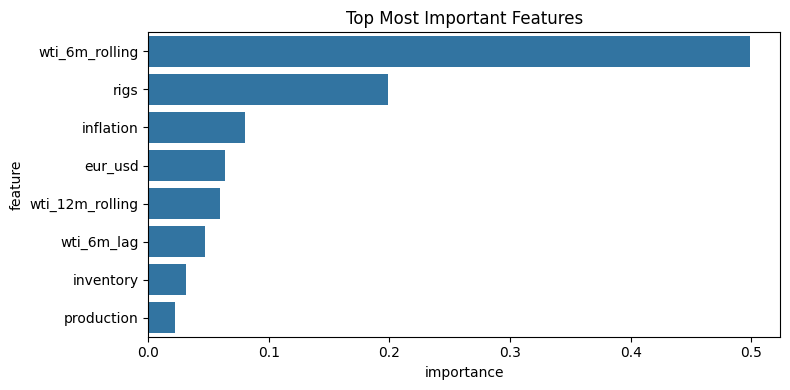

In [22]:
# Visualize feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top Most Important Features')
plt.tight_layout()
plt.show()

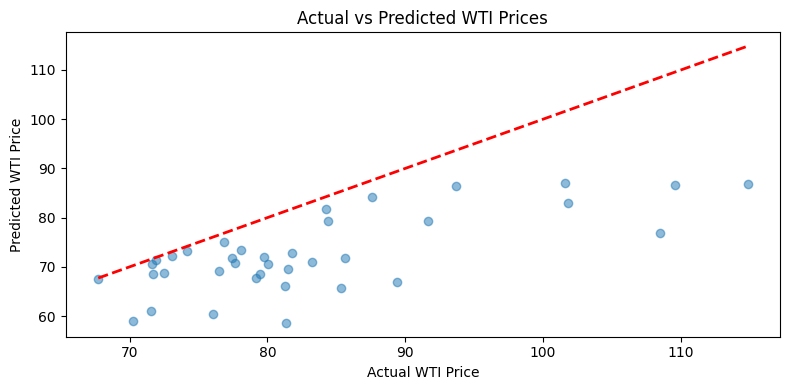

In [23]:
# Plot predictions
y_pred = final_model.predict(X_test)
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual WTI Price')
plt.ylabel('Predicted WTI Price')
plt.title('Actual vs Predicted WTI Prices')
plt.tight_layout()
plt.show()

## 5. Save Model Artifacts

In [24]:
# Save model and related files
print("\nSaving model and related files...")
output_date = datetime.now().strftime('%Y%m%d')
output_dir = os.path.join(get_project_root(), 'models', f'models_{output_date}')
os.makedirs(output_dir, exist_ok=True)

# Save model and scaler
joblib.dump(final_model, os.path.join(output_dir, f'best_model_{output_date}.joblib'))
joblib.dump(scaler, os.path.join(output_dir, f'scaler_{output_date}.joblib'))

# Update and save model info
model_info['training_data'] = os.path.basename(training_file)
model_info['training_date'] = output_date
model_info_path = os.path.join(output_dir, f'model_info_{output_date}.json')

with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print("\nTraining complete! Model and related files saved to:", output_dir)


Saving model and related files...

Training complete! Model and related files saved to: c:\Users\arailym\Projects\Energy-price-Prediction-DE\models\models_20241222
